In [1]:
from keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, binary_focal_jaccard_loss, binary_focal_dice_loss
from segmentation_models.metrics import iou_score

from albumentations import Resize

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


0


In [2]:

class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'../data/val_test', image_folder='img/', mask_folder='masks/', 
                 batch_size=1, image_size=768, nb_y_features=1, 
                 augmentation=None,
                 suffle=True):
        self.image_path = os.path.join(root_dir, image_folder)
        self.mask_path = os.path.join(root_dir, mask_folder)
        self.image_filenames = os.listdir(os.path.join(root_dir, image_folder))
        self.mask_names = os.listdir(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

        
    def read_image_mask(self, image_name, mask_name):
        return imread(self.image_path + image_name)/255, (imread(self.mask_path + mask_name, as_gray=True) > 0).astype(np.int8)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

        for i, sample_index in enumerate(indexes):

            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
                 
           
            # if augmentation isnt defined, we assume its a test set. 
            # Because test images can have different sizes we resize it to be divisable by 32
            if  self.batch_size ==1:
               
                #augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                augmented = Resize(height=self.image_size, width=self.image_size)(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask']
                
                return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)
            else:
                
                augmented = Resize(height=self.image_size, width=self.image_size)(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(X_sample, a_min = 0, a_max=1)
                y[i, ...] = y_sample
                
        return X, y

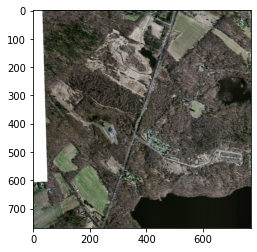

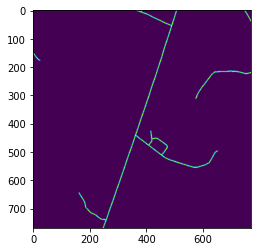

In [3]:
test_generator = DataGeneratorFolder(root_dir = '/Users/naveekum/Downloads/road_segmentation_ideal/training',
                                     image_folder = 'input/', 
                                     mask_folder = 'output/',
                                     batch_size = 1,
                                     nb_y_features = 1, augmentation = None)
Xtest, ytest = test_generator.__getitem__(3)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show() 

In [4]:
# setting generators
test_generator = DataGeneratorFolder(root_dir = '/Users/naveekum/Downloads/road_segmentation_ideal/testing', 
                           image_folder = 'input/', 
                           mask_folder = 'output/', 
                                   batch_size=1,
                                   nb_y_features = 1, augmentation = None)

train_generator = DataGeneratorFolder(root_dir = '/Users/naveekum/Downloads/road_segmentation_ideal/training', 
                                      image_folder = 'input/', 
                                      mask_folder = 'output/', 
                                      batch_size=4,
                                      image_size=512,
                                      nb_y_features = 1, augmentation = None)

In [5]:
model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)
model.compile(optimizer = Adam(), loss=binary_focal_jaccard_loss, metrics=[iou_score])


In [ ]:
model.fit_generator(train_generator, shuffle =True, epochs=1, validation_data = test_generator, verbose = 1)

Epoch 1/1


In [ ]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))  